In [ ]:
!pip install transformers datasets evaluate -q

In [ ]:
!pip install scikit-learn -q

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from sklearn.metrics import classification_report

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
dataset = load_dataset("tweet_eval", "sentiment")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [9]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [10]:

print(dataset['train'][0])

{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'label': 2}


In [11]:
import seaborn as sns

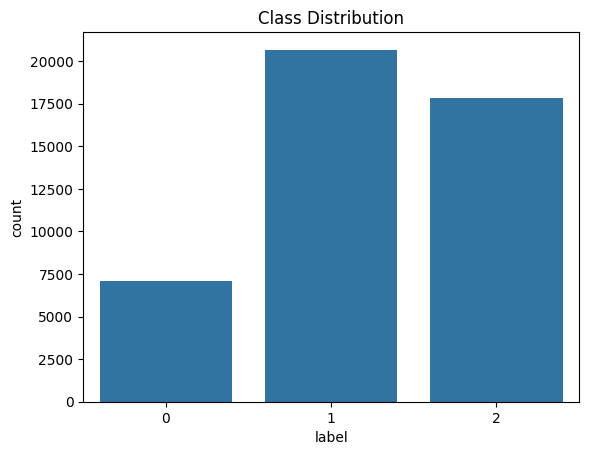

In [12]:
train_df = pd.DataFrame(dataset['train'])
sns.countplot(x=train_df['label'])
plt.title("Class Distribution")
plt.show()

In [13]:
print(train_df[train_df['label'] == 2].sample(3))  # Positive
print(train_df[train_df['label'] == 0].sample(3))

                                                    text  label
36270  Happy Monday!  The winners of our Foo Fighters...      2
24540  Friday - Dracula time again at the Leicester S...      2
42041  Took son to see Jurassic Park when he was 5, w...      2
                                                    text  label
3779   Steve Emerson on Sun News Network with Michael...      0
20386  Saudi Arabia hospital fire: 25 killed and over...      0
34936  "My law teacher was indirectly taunting me abo...      0


In [14]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=64)

In [16]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")


In [19]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
    }

In [20]:
!pip install --upgrade transformers datasets evaluate -q


In [21]:

training_args = TrainingArguments(
    output_dir="./results",
    # Removed evaluation_strategy & save_strategy for compatibility
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50
)

In [22]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-524404708.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: justshikharbhargava (justshikharbhargava-iiit-bhopal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,1.005700
100,0.888100
150,0.755700
200,0.755500
250,0.704600
300,0.705200
350,0.720300
400,0.736100
450,0.665700
500,0.717300


TrainOutput(global_step=8553, training_loss=0.47154256140127887, metrics={'train_runtime': 1832.7368, 'train_samples_per_second': 74.667, 'train_steps_per_second': 4.667, 'total_flos': 4500719456123520.0, 'train_loss': 0.47154256140127887, 'epoch': 3.0})

In [24]:
results = trainer.evaluate(tokenized_datasets["test"])
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.9074873328208923, 'eval_accuracy': 0.6882937154021491, 'eval_f1': 0.6884494934490134, 'eval_runtime': 46.6894, 'eval_samples_per_second': 263.101, 'eval_steps_per_second': 16.449, 'epoch': 3.0}


In [25]:
predictions = trainer.predict(tokenized_datasets["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.71      0.70      0.71      3972
     Neutral       0.71      0.66      0.68      5937
    Positive       0.62      0.74      0.67      2375

    accuracy                           0.69     12284
   macro avg       0.68      0.70      0.69     12284
weighted avg       0.69      0.69      0.69     12284



In [26]:
test_tweets = [
    "I absolutely love this product! 😍",
    "This is the worst thing ever...",
    "It's okay, nothing special."
]

In [27]:
inputs = tokenizer(test_tweets, return_tensors="pt", padding=True, truncation=True).to(device)
outputs = model(**inputs)
preds = torch.argmax(outputs.logits, dim=-1)
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

In [28]:
for t, p in zip(test_tweets, preds):
    print(f"Tweet: {t} | Sentiment: {label_map[p.item()]}")

Tweet: I absolutely love this product! 😍 | Sentiment: Positive
Tweet: This is the worst thing ever... | Sentiment: Negative
Tweet: It's okay, nothing special. | Sentiment: Neutral
